# Data exploration and visualization

This dataset is a 4G LTE mobile network counters data for a major MENA operator on Huawei infra. The dataset being worked on is a subset of the full dataset focused on countes used to calcualte high level performance KPIs for a period of one week. This notebook is an initial data exploration and visualization for this dataset before jumping into any forecasting modeling

### Load libraries required for the analysis

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
import calendar
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm

### Load the dataset and check the columns

In [876]:
#df=pd.read_excel('Traffic.xlsx')
df.head()

,Start Time,Cell,L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None),L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None),L.Traffic.UL.SCH.QPSK.TB (None),L.Traffic.UL.SCH.QPSK.TB.bits (bit),L.Traffic.UL.SCH.QPSK.TB.Retrans (None),L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit),L.Traffic.DL.PktDelay.Num.QCI.9 (packet),L.Traffic.DL.PktDelay.Time.QCI.9 (ms),...,L.Traffic.UL.SCH.16QAM.TB (None),L.Traffic.UL.SCH.16QAM.TB.bits (bit),L.Traffic.UL.SCH.16QAM.TB.Retrans (None),L.Traffic.UL.SCH.16QAM.TB.Retrans.bits (bit),L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None),L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None),L.Traffic.UL.SCH.64QAM.TB (None),L.Traffic.UL.SCH.64QAM.TB.bits (bit),L.Traffic.UL.SCH.64QAM.TB.Retrans (None),L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)
0,2013-08-28,"Local cell identity=2, Cell Name=eNB_2786_2",16296,2631,153575,101906552,26414,15092480,785527,190975757,...,513181,1215761008,40201,98515328,0,0,0,0,0,0
1,2013-08-28,"Local cell identity=1, Cell Name=eNB_2282_1",12856,433,111023,87983752,15671,10747464,1428194,753605164,...,670664,1167179360,47727,94020520,0,0,0,0,0,0
2,2013-08-28,"Local cell identity=0, Cell Name=eNB_2786_0",13636,641,132016,89939024,17448,10200736,1002134,290990065,...,819410,1921970648,49922,117234944,0,0,0,0,0,0
3,2013-08-28,"Local cell identity=0, Cell Name=eNB_5265_0",11903,82,126081,151564696,12790,20082880,617281,98672335,...,969115,1215749536,38963,53750968,0,0,0,0,0,0
4,2013-08-28,"Local cell identity=2, Cell Name=eNB_5265_2",41385,7867,259625,183131112,76076,32228320,1121723,510453204,...,561853,1208172496,44483,105478408,0,0,0,0,0,0


What are we dealing with here? it's a dataset that has a time stamp, along with the name of the cell. The cells are the 4G LTE sites that provide coverage to the service area. Each cell has a reading every 15 minutes as seen below (taken for one cell as an example). There are 768 readings for each cell which amounts to a full week's data. As seen in the head results, each column has numeric values for each reading. Each column is called a "counter" as it counts/calculates one variable every 15 mins and records it in the the dataset

In [879]:
df_subset=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_2786_2']
df_subset['Start Time']

0        2013-08-28 00:00:00
484      2013-08-28 00:15:00
564      2013-08-28 00:30:00
824      2013-08-28 00:45:00
1190     2013-08-28 01:00:00
                 ...        
209057   2013-09-04 22:45:00
209331   2013-09-04 23:00:00
209605   2013-09-04 23:15:00
209879   2013-09-04 23:30:00
210153   2013-09-04 23:45:00
Name: Start Time, Length: 768, dtype: datetime64[ns]

Ok. What columns are we dealing with? Let's have a look

In [880]:
df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 

There are a number of counters here. Counters included in the dataset are for each layer in the tech stack of 4G LTE airinterface. We are dealing in particular with PHY (bits transmitted/received, time to send/receive, block error rate for each modulation type etc..), MAC (packets transmitted/received), PDCP (Packets count, packets loss, PDCP compression stats), and NAS (Non-access startum session timers and counters). These counters and be used by themselves or in combination to come up with KPIs to monitor the performance/functionality of the 4G LTE network

What are the types of columns that we have? the expectation is to be dealing with numeric data. is that what we see?

In [881]:
df.dtypes

Start Time                                      datetime64[ns]
Cell                                                    object
L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)                 int64
L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)                 int64
L.Traffic.UL.SCH.QPSK.TB (None)                          int64
                                                     ...      
L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None)                int64
L.Traffic.UL.SCH.64QAM.TB (None)                         int64
L.Traffic.UL.SCH.64QAM.TB.bits (bit)                     int64
L.Traffic.UL.SCH.64QAM.TB.Retrans (None)                 int64
L.Traffic.UL.SCH.64QAM.TB.Retrans.bits (bit)             int64
Length: 82, dtype: object

Looks like the majority of the columns are numeric as expected. Cell name is an object as expected. Start time, which is a time stamp, was read correctly as datetime. Let's set Start time as the index of the dataframe as we are interested in analyzing the dataset as timeseries data. Also let's check the count of each data type in the dataset

In [857]:
df.set_index('Start Time',drop=False,inplace=True)

In [858]:
df.dtypes.value_counts()

int64             74
float64            5
object             2
datetime64[ns]     1
dtype: int64

Seems like there are two object columns, which is not expected. We expect to have one only (Cell name). Let's check what the second one is

In [872]:
obj_cols = []
for col in df.columns:
    if df[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

['Cell', 'DL RBLER (%)']

DL BLER (Block error rate) was read as an objet for some reason. This is not expected as we should be dealing with a float here (values from 0 to 1). Are there any missing values that were read as strings for example in the dataset? let's check the unique values

In [871]:
list(df['DL RBLER (%)'].unique())

[0.069,
 0.095,
 0.048,
 0.006,
 0.075,
 0.057,
 0.046,
 0.161,
 0.03,
 0.064,
 0.084,
 0.142,
 0.032,
 0.101,
 0.041,
 0.11,
 0.068,
 0.031,
 0.133,
 0.102,
 0.056,
 0.086,
 0.189,
 0.155,
 0.288,
 0.053,
 0.067,
 0.026,
 0.109,
 0.134,
 0.18,
 0.06,
 0.021,
 0.028,
 0.02,
 0.003,
 0.025,
 0.043,
 0.035,
 0.098,
 0.113,
 0.033,
 0.151,
 0.125,
 0.112,
 0.091,
 0.106,
 0.038,
 0.047,
 0.12,
 0.062,
 0.104,
 0.094,
 0.054,
 0.082,
 0.185,
 0.127,
 0.226,
 0.011,
 0.128,
 0.044,
 0.141,
 0.213,
 0.117,
 0.178,
 0.081,
 0.024,
 0.05,
 0.066,
 0.059,
 0.045,
 0.039,
 0.206,
 0.183,
 0.221,
 0.266,
 0.118,
 0.096,
 0.007,
 0.089,
 0.237,
 0.301,
 0.019,
 0.215,
 0.076,
 0.013,
 0.015,
 0.051,
 0.002,
 0.153,
 0.135,
 0.14,
 0.146,
 0.023,
 0.04,
 0.014,
 0.08,
 0.242,
 0.093,
 0.136,
 0.099,
 0.037,
 0.19,
 0.073,
 0.131,
 0.144,
 0.012,
 0.071,
 0.157,
 0.042,
 0.191,
 0.23,
 0.018,
 0.065,
 0.119,
 0.171,
 0.13,
 0.083,
 0.126,
 0.058,
 0.129,
 0.077,
 0.052,
 0.034,
 0.061,
 0.156,
 0.02

Ok.. There is a value that was read as 'NIL'. Not clear where that came from. But we'll simply set it as na then fill it with the median value in the dataset. Let's also check the non numeric objects' count again

In [873]:
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
obj_cols = []
for col in df.columns:
    if df[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

['Cell']

In [107]:

df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)

df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 

In [108]:
df.isna().sum()
df.dtypes.value_counts()

int64             74
float64            8
object             3
datetime64[ns]     1
dtype: int64

In [123]:
df['Name_of_day']=df['Start Time'].dt.day_name()

cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cat_type = CategoricalDtype(categories=cats, ordered=True)
df['Name_of_day'] = df['Name_of_day'].astype(cat_type)

df['Name_of_day'].unique()

[Wednesday, Thursday, Friday, Saturday, Sunday, Monday, Tuesday]
Categories (7, object): [Monday < Tuesday < Wednesday < Thursday < Friday < Saturday < Sunday]

In [124]:
df['hour of day']=df['Start Time'].dt.strftime('%H')
df['hour of day'].unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

### User Download Throughput analysis

In [165]:
plotdays=df.groupby(['Name_of_day'])['DL user tput'].mean()
plothours=df.groupby(['hour of day'])['DL user tput'].mean()
plotUdays=df.groupby(['Name_of_day'])['L.Traffic.User.Avg (None)'].mean()
plotUhours=df.groupby(['hour of day'])['L.Traffic.User.Avg (None)'].mean()

In [166]:
plotdays=pd.DataFrame(plotdays)
plotdays['Name_of_day']=plotdays.index
plotdays.reset_index(level=None, drop=True, inplace=True)

plothours=pd.DataFrame(plothours)
plothours['hour of day']=plothours.index
plothours.reset_index(level=None, drop=True, inplace=True)


plotUdays=pd.DataFrame(plotUdays)
plotUdays['Name_of_day']=plotUdays.index
plotUdays.reset_index(level=None, drop=True, inplace=True)


plotUhours=pd.DataFrame(plotUhours)
plotUhours['hour of day']=plotUhours.index


plotUhours.reset_index(level=None, drop=True, inplace=True)


In [167]:
plotUhours

,L.Traffic.User.Avg (None),hour of day
0,48.361271,00
1,46.110099,01
2,43.723599,02
3,41.793934,03
4,40.806485,04
5,40.997351,05
6,39.600980,06
7,37.749523,07
8,36.430553,08
9,36.355203,09


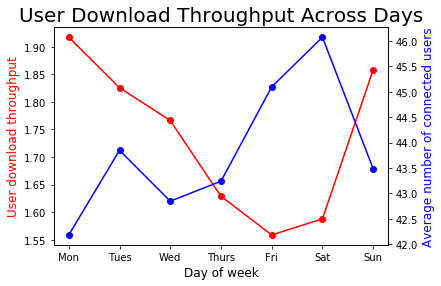

In [164]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('User Download Throughput Across Days',fontsize=20);
# make a plot
ax.plot(plotdays['Name_of_day'],
        plotdays['DL user tput'],
        color="red", 
        marker="o")

# set x-axis label
ax.set_xlabel("Day of week", fontsize = 12)

# set y-axis label
ax.set_ylabel("User download throughput",
              color="red",
              fontsize=12)



# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(plotUdays['Name_of_day'], plotUdays['L.Traffic.User.Avg (None)'],color="blue",marker="o")
ax2.set_ylabel("Average number of connected users",color="blue",fontsize=12)
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=12);
plt.show()



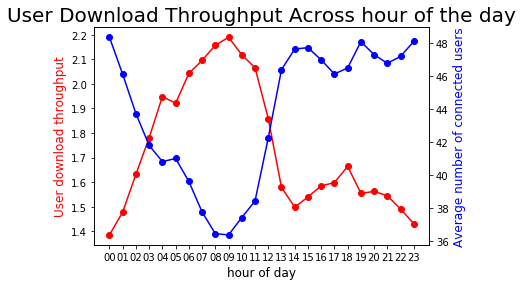

In [169]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('User Download Throughput Across hour of the day',fontsize=20);
# make a plot
ax.plot(plothours['hour of day'],
        plothours['DL user tput'],
        color="red", 
        marker="o")

# set x-axis label
ax.set_xlabel("hour of day", fontsize = 12)

# set y-axis label
ax.set_ylabel("User download throughput",
              color="red",
              fontsize=12)



# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(plotUhours['hour of day'], plotUhours['L.Traffic.User.Avg (None)'],color="blue",marker="o")
ax2.set_ylabel("Average number of connected users",color="blue",fontsize=12)
#plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=12);
plt.show()

## Unsupervised Cell analysis

#### safsafd

In [252]:
import matplotlib.pyplot as plt
#from kneed import KneeLocator
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [519]:
df.columns

Index(['Start Time', 'Cell', 'L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.QPSK.TB (None)',
       'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
       'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
       'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
       'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
       'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
       'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
       'L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)', 'DL RBLER (%)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 

In [663]:
df_cluster=df[['Cell','DL user tput','DL cell tput','hour of day','L.Traffic.User.Avg (None)','L.Thrp.bits.DL (bit)']]
df_cluster.reset_index(level=None, drop=True, inplace=True)
df_cluster['hour of day']=df_cluster['hour of day'].astype(int)

df_cluster['L.Traffic.User.Avg (None)']=df_cluster['L.Traffic.User.Avg (None)'].replace(0.0,1.0)

df_cluster['Traffic Vol per user']=df_cluster['L.Thrp.bits.DL (bit)']/(df_cluster['L.Traffic.User.Avg (None)']*1000000)

#df_cluster

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [669]:
df_cluster

,Cell,DL user tput,DL cell tput,hour of day,L.Traffic.User.Avg (None),L.Thrp.bits.DL (bit),Traffic Vol per user,time of day
0,"Local cell identity=2, Cell Name=eNB_2786_2",0.874756,5.615273,0,47.820,5053745384,105.682672,EV
1,"Local cell identity=1, Cell Name=eNB_2282_1",0.465525,13.046722,0,88.716,11742049736,132.355491,EV
2,"Local cell identity=0, Cell Name=eNB_2786_0",1.126516,7.423029,0,43.926,6680726256,152.090476,EV
3,"Local cell identity=0, Cell Name=eNB_5265_0",1.195236,6.139347,0,27.219,5525412696,202.998372,EV
4,"Local cell identity=2, Cell Name=eNB_5265_2",0.727086,10.693363,0,63.032,9624026832,152.684776,EV
...,...,...,...,...,...,...,...,...
256488,"Local cell identity=1, Cell Name=eNB_3894-1",2.473142,4.012635,23,20.160,3611371328,179.135483,EV
256489,"Local cell identity=2, Cell Name=eNB_2462-2",2.187025,4.323894,23,21.517,3887180416,180.656245,EV
256490,"Local cell identity=1, Cell Name=eNB_2157-1",1.639771,6.142340,23,25.619,5528105968,215.781489,EV
256491,"Local cell identity=1, Cell Name=eNB_2169-1",1.468915,8.567474,23,30.619,7710727048,251.828180,EV


In [665]:
conditions = [
    (df_cluster['hour of day'] >= 1) & (df_cluster['hour of day'] < 5),
    (df_cluster['hour of day'] >= 5) & (df_cluster['hour of day'] < 9),
    (df_cluster['hour of day'] >= 9) & (df_cluster['hour of day'] < 16),
    (df_cluster['hour of day'] >= 16) & (df_cluster['hour of day'] < 21),
    (df_cluster['hour of day'] >= 21) | (df_cluster['hour of day'] == 0)
]



values = ['NO', 'EB', 'WH', 'AW','EV']

df_cluster['time of day'] = np.select(conditions, values)


C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [666]:

cluster_dltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL user tput'].mean())
cluster_avguser=pd.DataFrame(df_cluster.groupby(['Cell'])['L.Traffic.User.Avg (None)'].mean())
cluster_celltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL cell tput'].mean())
cluster_traffic=pd.DataFrame(df_cluster.groupby(['Cell'])['Traffic Vol per user'].mean())
cluster_avguser

,L.Traffic.User.Avg (None)
Cell,
"Local cell identity=0, Cell Name=eNB_2014-0",66.713497
"Local cell identity=0, Cell Name=eNB_2077-0",47.065283
"Local cell identity=0, Cell Name=eNB_2080_0",21.381023
"Local cell identity=0, Cell Name=eNB_2151-0",112.719250
"Local cell identity=0, Cell Name=eNB_2152-0",49.159100
...,...
"Local cell identity=2, Cell Name=eNB_5057_2",27.241456
"Local cell identity=2, Cell Name=eNB_5067_2",54.425004
"Local cell identity=2, Cell Name=eNB_5250_2",50.004503


In [842]:

cluster_dltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL user tput'].mean())
cluster_avguser=pd.DataFrame(df_cluster.groupby(['Cell'])['L.Traffic.User.Avg (None)'].mean())
cluster_celltput=pd.DataFrame(df_cluster.groupby(['Cell'])['DL cell tput'].mean())
cluster_traffic=pd.DataFrame(df_cluster.groupby(['Cell','time of day'])['Traffic Vol per user'].mean())

#cluster_dltput=cluster_dltput.unstack()
#cluster_avguser=cluster_avguser.unstack()
#cluster_celltput=cluster_celltput.unstack()
cluster_traffic=cluster_traffic.unstack()

#cluster_dltput.columns=['AW_tput','EB_tput','NO_tput','WH_tput','EV_tput']
#cluster_avguser.columns=['AW_users','EB_users','NO_users','WH_users','EV_users']
#cluster_celltput.columns=['AW_cell_tput','EB_cell_tput','EV_cell_tput','NO_cell_tput','WH_cell_tput']
cluster_traffic.columns=['AW_TV','EB_TV','EV_TV','NO_TV','WH_TV']

cluster_dltput['Cell']=cluster_dltput.index
cluster_dltput.reset_index(level=None, drop=True, inplace=True)
cluster_avguser['Cell']=cluster_avguser.index
cluster_avguser.reset_index(level=None, drop=True, inplace=True)


cluster_merge=pd.merge(cluster_dltput, cluster_avguser, on="Cell")
cluster_merge=pd.merge(cluster_merge, cluster_celltput, on="Cell")
cluster_merge=pd.merge(cluster_merge, cluster_traffic, on="Cell")

#cluster_merge['low_to_high_ratio']=cluster_merge['EB_users']/cluster_merge['NO_users']




In [745]:

#cluster_dltput=df_cluster.groupby(['Cell','time of day'])['DL user tput'].mean()
#cluster_avguser=df_cluster.groupby(['Cell','time of day'])['L.Traffic.User.Avg (None)'].mean()

#cluster_merge=pd.merge(cluster_dltput, cluster_avguser, on="Cell")
cluster_merge

,DL user tput,Cell,L.Traffic.User.Avg (None),DL cell tput,AW_TV,EB_TV,EV_TV,NO_TV,WH_TV
0,1.103360,"Local cell identity=0, Cell Name=eNB_2014-0",66.713497,11.155545,140.373862,153.026912,147.252525,151.927306,159.374173
1,1.599800,"Local cell identity=0, Cell Name=eNB_2077-0",47.065283,7.519939,147.818109,154.055717,145.116804,146.214131,136.174092
2,1.892283,"Local cell identity=0, Cell Name=eNB_2080_0",21.381023,5.336236,226.789031,157.999599,286.228206,211.733405,217.523486
3,0.752215,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250,10.579933,83.408103,88.225904,80.848359,78.290517,92.056703
4,1.966447,"Local cell identity=0, Cell Name=eNB_2152-0",49.159100,9.560230,167.187647,164.191439,189.340946,185.237201,169.319420
...,...,...,...,...,...,...,...,...,...
329,2.040793,"Local cell identity=2, Cell Name=eNB_5057_2",27.241456,6.120542,229.491047,129.675423,239.872866,181.679507,203.656092
330,1.942831,"Local cell identity=2, Cell Name=eNB_5067_2",54.425004,10.121535,166.627839,165.829025,165.827576,168.052548,167.652736
331,0.914901,"Local cell identity=2, Cell Name=eNB_5250_2",50.004503,7.748157,139.008284,152.576353,129.072772,137.620535,142.346614
332,1.884600,"Local cell identity=2, Cell Name=eNB_5264_2",49.338763,8.530458,150.895001,165.243491,163.304389,149.951775,154.028362


In [622]:
cluster_merge

,DL user tput,Cell,L.Traffic.User.Avg (None),DL cell tput,Traffic per user
0,1.103360,"Local cell identity=0, Cell Name=eNB_2014-0",66.713497,11.155545,151.096479
1,1.599800,"Local cell identity=0, Cell Name=eNB_2077-0",47.065283,7.519939,144.743992
2,1.892283,"Local cell identity=0, Cell Name=eNB_2080_0",21.381023,5.336236,220.018933
3,0.752215,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250,10.579933,85.454023
4,1.966447,"Local cell identity=0, Cell Name=eNB_2152-0",49.159100,9.560230,174.010522
...,...,...,...,...,...
329,2.040793,"Local cell identity=2, Cell Name=eNB_5057_2",27.241456,6.120542,199.081628
330,1.942831,"Local cell identity=2, Cell Name=eNB_5067_2",54.425004,10.121535,166.897706
331,0.914901,"Local cell identity=2, Cell Name=eNB_5250_2",50.004503,7.748157,140.356098
332,1.884600,"Local cell identity=2, Cell Name=eNB_5264_2",49.338763,8.530458,156.111340


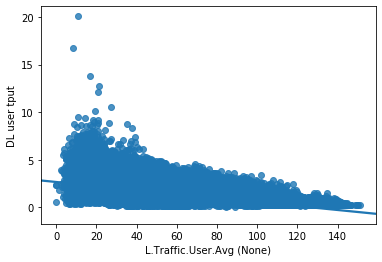

In [466]:
from scipy.stats import pearsonr
sns.regplot(cluster_merge['L.Traffic.User.Avg (None)'],cluster_merge['DL user tput'])
#pearsonr(df_cluster['L.Traffic.User.Avg (None)'],df_cluster['DL user tput'])

In [843]:
cluster_merge=cluster_merge.set_index('Cell')

bin_labels_tput = [1,2,3,4,5]
bin_labels_users = [1,2,3,4,5]
cluster_merge['bins_DL_user_tput'] = pd.qcut(cluster_merge['DL user tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_users'] = pd.qcut(cluster_merge['L.Traffic.User.Avg (None)'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_cell_tput'] = pd.qcut(cluster_merge['DL cell tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_AW_TV'] = pd.qcut(cluster_merge['AW_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_EB_TV'] = pd.qcut(cluster_merge['EB_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_EV_TV'] = pd.qcut(cluster_merge['EV_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_NO_TV'] = pd.qcut(cluster_merge['NO_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_WH_TV'] = pd.qcut(cluster_merge['WH_TV'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)

scaled=cluster_merge[['bins_DL_user_tput','bins_users','bins_cell_tput','bins_AW_TV','bins_EB_TV','bins_EV_TV',
                     'bins_NO_TV','bins_WH_TV']]

#,'bins_AW_users','bins_EB_users','bins_NO_users','bins_WH_users','bins_EV_users'
#'bins_AW_tput','bins_EB_tput','bins_NO_tput','bins_WH_tput','bins_EV_tput'


In [673]:
scaled

,bins_DL_user_tput,bins_users,bins_cell_tput,bins_traffic_vol
Cell,,,,
"Local cell identity=0, Cell Name=eNB_2014-0",1,5,5,2
"Local cell identity=0, Cell Name=eNB_2077-0",3,4,3,2
"Local cell identity=0, Cell Name=eNB_2080_0",4,1,1,5
"Local cell identity=0, Cell Name=eNB_2151-0",1,5,5,1
"Local cell identity=0, Cell Name=eNB_2152-0",4,4,5,4
...,...,...,...,...
"Local cell identity=2, Cell Name=eNB_5057_2",4,2,2,5
"Local cell identity=2, Cell Name=eNB_5067_2",4,4,5,3
"Local cell identity=2, Cell Name=eNB_5250_2",1,4,3,2


In [838]:
cluster_merge=cluster_merge.set_index('Cell')

#StandardScaler
#MinMaxScaler

scaler = StandardScaler()
# transform data
scaled = scaler.fit_transform(cluster_merge)
scaled=pd.DataFrame(scaled)
scaled.columns=['bins_DL_user_tput','bins_users','DL cell tput','AW_TV','EB_TV','EV_TV','NO_TV','WH_TV']
scaled

,bins_DL_user_tput,bins_users,DL cell tput,AW_TV,EB_TV,EV_TV,NO_TV,WH_TV
0,-1.186186,1.163458,1.715154,-0.612779,0.036273,-0.594818,-0.427695,-0.096989
1,-0.258721,0.169994,0.044561,-0.396079,0.070946,-0.648116,-0.579753,-0.802356
2,0.287704,-1.128668,-0.958869,1.902746,0.203864,2.873397,1.164057,1.670963
3,-1.842207,3.489627,1.450655,-2.271039,-2.147675,-2.251971,-2.387554,-2.143687
4,0.426261,0.275863,0.982092,0.167764,0.412544,0.455522,0.458855,0.205383
...,...,...,...,...,...,...,...,...
329,0.565155,-0.832349,-0.598474,1.981401,-0.750728,1.716574,0.364166,1.249344
330,0.382140,0.542120,1.240017,0.151468,0.467734,-0.131268,0.001481,0.154710
331,-1.538272,0.318609,0.149429,-0.652531,0.021088,-1.048504,-0.808473,-0.614689
332,0.273350,0.284947,0.508903,-0.306511,0.448000,-0.194235,-0.480275,-0.259521


In [844]:

#'bins_DL_user_tput','bins_users','bins_cell_tput','bins_AW_TV','bins_EB_TV','bins_EV_TV','bins_NO_TV','bins_WH_TV'
#'bins_DL_user_tput','bins_users','bins_cell_tput','bins_AW_TV','bins_EB_TV','bins_EV_TV','bins_NO_TV','bins_WH_TV'

scaled=scaled[['bins_DL_user_tput','bins_users','bins_cell_tput','bins_AW_TV','bins_EB_TV','bins_EV_TV','bins_NO_TV','bins_WH_TV']]
model = KMeans(n_clusters=4,random_state=100) 
kmeans = model.fit(scaled)


In [845]:
cluster_merge['cluster']=kmeans.labels_



cluster_merge_stats=cluster_merge.groupby(['cluster'])['DL user tput','L.Traffic.User.Avg (None)','DL cell tput','AW_TV','EB_TV','EV_TV','NO_TV','WH_TV'].mean()

cluster_merge_stats[['DL user tput','L.Traffic.User.Avg (None)','DL cell tput','AW_TV','EB_TV','EV_TV','NO_TV','WH_TV']]
#.plot()

,DL user tput,L.Traffic.User.Avg (None),DL cell tput,AW_TV,EB_TV,EV_TV,NO_TV,WH_TV
cluster,,,,,,,,
0,1.221484,64.797163,8.894389,124.700548,126.821677,127.743744,129.046675,128.423355
1,2.120843,27.742232,6.131273,194.354885,180.218945,213.789998,207.973344,197.076590
2,2.127679,29.696033,5.450955,169.597405,137.919423,178.381332,165.763387,161.467071
3,1.607327,48.003868,8.722796,160.221341,159.341936,166.737066,168.966748,163.397904


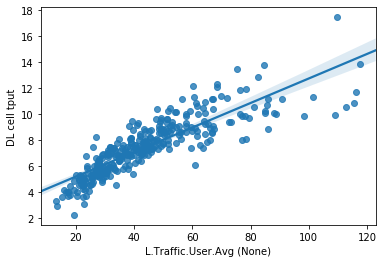

In [718]:
sns.regplot(cluster_merge['L.Traffic.User.Avg (None)'],cluster_merge['DL cell tput'])

In [816]:
from sklearn.decomposition import PCA
pca_cells = PCA(n_components=4)
principalComponents_cells = pca_cells.fit_transform(scaled)


principal_cells_Df = pd.DataFrame(data = principalComponents_cells
             , columns = ['principal component 1', 'principal component 2','principal component 3','principal component 4'])

In [817]:
print('Explained variation per principal component: {}'.format(pca_cells.explained_variance_ratio_))

Explained variation per principal component: [0.67181022 0.14088283 0.06889172 0.05093976]


In [818]:
# Principal components correlation coefficients
loadings = pca_cells.components_
 
# Number of features before PCA
n_features = pca_cells.n_features_
 
# Feature names before PCA
feature_names = scaled.columns
 
# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))
 
# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')
loadings_df

,PC1,PC2,PC3,PC4
feature_names,,,,
bins_DL_user_tput,0.322905,0.198059,0.603001,-0.682197
bins_users,-0.371570,-0.405960,0.241361,-0.067958
bins_cell_tput,-0.272295,-0.670333,0.366640,-0.009245
bins_AW_TV,0.387280,-0.126239,0.296863,0.356939
bins_EB_TV,0.292181,-0.463956,-0.558898,-0.498092
bins_EV_TV,0.402958,-0.095861,0.191902,0.246314
bins_NO_TV,0.376380,-0.230127,-0.079066,-0.039107
bins_WH_TV,0.379647,-0.230830,-0.011681,0.303648


In [413]:
df_cluster=df[['Cell','DL user tput','Name_of_day','L.Traffic.User.Avg (None)']]
df_cluster.reset_index(level=None, drop=True, inplace=True)
df_cluster['Name_of_day']=df_cluster['Name_of_day'].astype(str)
df_cluster

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Cell,DL user tput,Name_of_day,L.Traffic.User.Avg (None)
0,"Local cell identity=2, Cell Name=eNB_2786_2",0.874756,Wednesday,47.820
1,"Local cell identity=1, Cell Name=eNB_2282_1",0.465525,Wednesday,88.716
2,"Local cell identity=0, Cell Name=eNB_2786_0",1.126516,Wednesday,43.926
3,"Local cell identity=0, Cell Name=eNB_5265_0",1.195236,Wednesday,27.219
4,"Local cell identity=2, Cell Name=eNB_5265_2",0.727086,Wednesday,63.032
...,...,...,...,...
256488,"Local cell identity=1, Cell Name=eNB_3894-1",2.473142,Wednesday,20.160
256489,"Local cell identity=2, Cell Name=eNB_2462-2",2.187025,Wednesday,21.517
256490,"Local cell identity=1, Cell Name=eNB_2157-1",1.639771,Wednesday,25.619
256491,"Local cell identity=1, Cell Name=eNB_2169-1",1.468915,Wednesday,30.619


In [414]:

cluster_dltput=df_cluster.groupby(['Cell','Name_of_day'])['DL user tput'].mean()
cluster_avguser=df_cluster.groupby(['Cell','Name_of_day'])['L.Traffic.User.Avg (None)'].mean()
cluster_dltput=cluster_dltput.unstack()
cluster_avguser=cluster_avguser.unstack()


cluster_dltput.columns=['Fri_tput','Mon_tput','Sat_tput','Sun_tput','Thu_tput','Tue_tput','Wed_tput']
cluster_avguser.columns=['Fri_users','Mon_users','Sat_users','Sun_users','Thu_users','Tue_users','Wed_users']

cluster_dltput['Cell']=cluster_dltput.index
cluster_dltput.reset_index(level=None, drop=True, inplace=True)
cluster_avguser['Cell']=cluster_avguser.index
cluster_avguser.reset_index(level=None, drop=True, inplace=True)


cluster_merge=pd.merge(cluster_dltput, cluster_avguser, on="Cell")

cluster_merge['low_to_high_ratio']=cluster_merge['Fri_tput']/cluster_merge['Mon_tput']

In [415]:
cluster_merge=cluster_merge.set_index('Cell')

bin_labels_tput = [1,2,3,4,5]
bin_labels_users = [1,2,3,4,5]
cluster_merge['bins_Fri_tput'] = pd.qcut(cluster_merge['Fri_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Mon_tput'] = pd.qcut(cluster_merge['Mon_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Sat_tput'] = pd.qcut(cluster_merge['Sat_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Sun_tput'] = pd.qcut(cluster_merge['Sun_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Thu_tput'] = pd.qcut(cluster_merge['Thu_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Tue_tput'] = pd.qcut(cluster_merge['Tue_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Wed_tput'] = pd.qcut(cluster_merge['Wed_tput'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)

cluster_merge['bins_Fri_users'] = pd.qcut(cluster_merge['Fri_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Mon_users'] = pd.qcut(cluster_merge['Mon_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Sat_users'] = pd.qcut(cluster_merge['Sat_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Sun_users'] = pd.qcut(cluster_merge['Sun_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Thu_users'] = pd.qcut(cluster_merge['Thu_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Tue_users'] = pd.qcut(cluster_merge['Tue_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)
cluster_merge['bins_Wed_users'] = pd.qcut(cluster_merge['Wed_users'],q=[0, .2, .4, .6, .8, 1],labels=bin_labels_tput)

scaled=cluster_merge[['bins_Fri_tput','bins_Mon_tput','bins_Sat_tput','bins_Sun_tput','bins_Thu_tput','bins_Tue_tput',
                     'bins_Wed_tput','bins_Fri_users','bins_Mon_users','bins_Sat_users','bins_Sun_users','bins_Thu_users','bins_Tue_users','bins_Wed_users']]


In [404]:
cluster_merge=cluster_merge.set_index('Cell')

#StandardScaler
#MinMaxScaler

scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(cluster_merge)
scaled=pd.DataFrame(scaled)
scaled.columns=['Fri_tput','Mon_tput','Sat_tput','Sun_tput','Thu_tput','Tue_tput','Wed_tput',
                'Fri_users','Mon_users','Sat_users','Sun_users','Thu_users','Tue_users','Wed_users','low_to_high_ratio']
scaled

,Fri_tput,Mon_tput,Sat_tput,Sun_tput,Thu_tput,Tue_tput,Wed_tput,Fri_users,Mon_users,Sat_users,Sun_users,Thu_users,Tue_users,Wed_users,low_to_high_ratio
0,0.176888,0.200128,0.128998,0.208566,0.208131,0.269756,0.173667,0.509582,0.459014,0.529432,0.504979,0.507408,0.488909,0.503058,0.322321
1,0.390327,0.309237,0.270687,0.386346,0.316927,0.283201,0.362412,0.316929,0.280630,0.368600,0.329418,0.335582,0.317197,0.308221,0.552311
2,0.413212,0.382780,0.352978,0.458994,0.474252,0.408391,0.425710,0.085951,0.087765,0.075286,0.079373,0.091269,0.089853,0.086440,0.449408
3,0.033587,0.107525,0.056394,0.111363,0.074842,0.134152,0.112605,0.935376,0.869778,0.977705,1.000000,0.924920,0.888963,0.892442,0.093076
4,0.391575,0.387347,0.310184,0.530661,0.419948,0.503823,0.485952,0.372871,0.309489,0.385665,0.306927,0.327666,0.342030,0.334086,0.405941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0.464335,0.421564,0.384999,0.452888,0.480251,0.432084,0.522745,0.169001,0.106175,0.174113,0.135210,0.144517,0.128402,0.126262,0.466802
330,0.376979,0.446410,0.292787,0.673870,0.369521,0.425865,0.432909,0.398951,0.340655,0.430832,0.351443,0.389157,0.394849,0.397345,0.299128
331,0.132275,0.139629,0.121956,0.116449,0.117028,0.172869,0.155793,0.375569,0.328961,0.333137,0.337771,0.355870,0.341774,0.353574,0.349435
332,0.363506,0.335960,0.316555,0.403079,0.501860,0.497599,0.458022,0.340642,0.355156,0.348208,0.380486,0.295480,0.350834,0.330786,0.446525


In [814]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled)
    distortions.append(kmeanModel.inertia_)

C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


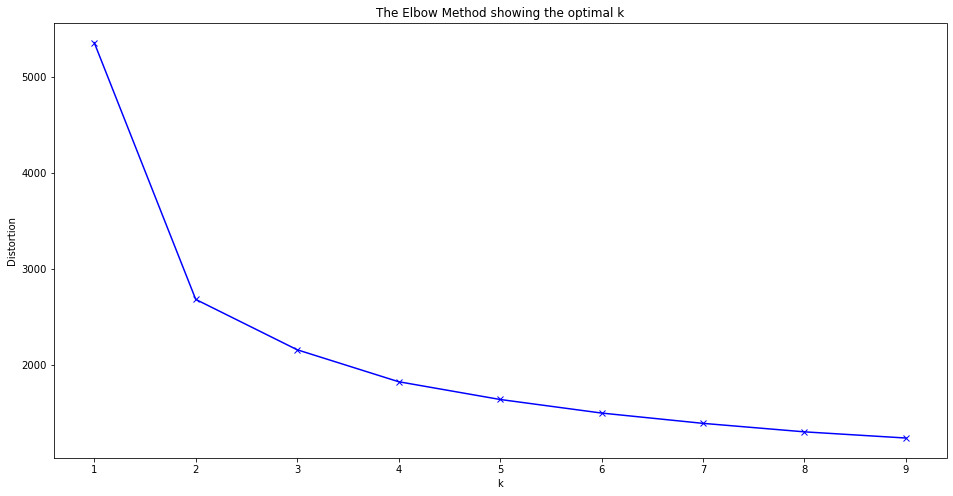

In [815]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [418]:

model = KMeans(n_clusters=2, random_state=42) 
kmeans = model.fit(scaled)

In [419]:
cluster_merge['cluster']=kmeans.labels_



cluster_merge_stats=cluster_merge.groupby(['cluster'])['Fri_tput','Mon_tput','Sat_tput','Sun_tput','Thu_tput','Tue_tput','Wed_tput',
                                                      'Fri_users','Mon_users','Sat_users','Sun_users','Thu_users','Tue_users','Wed_users','low_to_high_ratio'].mean()

cluster_merge_stats[['Fri_tput','Mon_tput','Sat_tput','Sun_tput','Thu_tput','Tue_tput','Wed_tput','low_to_high_ratio']]
#.plot()

,Fri_tput,Mon_tput,Sat_tput,Sun_tput,Thu_tput,Tue_tput,Wed_tput,low_to_high_ratio
cluster,,,,,,,,
0,1.118801,1.555189,1.153682,1.495646,1.209607,1.435505,1.360685,0.719878
1,1.963917,2.250050,1.987221,2.186058,2.014851,2.184193,2.139060,0.877308


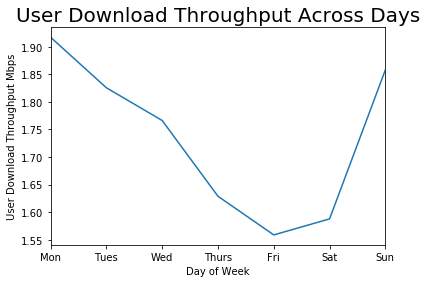

In [131]:
plotdays.plot()
plt.title('User Download Throughput Across Days',fontsize=20);
plt.ylabel('User Download Throughput Mbps', fontsize=10);
plt.xlabel('Day of Week', fontsize=10);
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'), fontsize=10);
plt.yticks(fontsize=10);

In [3]:
mean_users=df[['Cell','L.Traffic.User.Avg (None)']].groupby('Cell').mean().reset_index()
mean_users.sort_values('L.Traffic.User.Avg (None)', ascending=False)

,Cell,L.Traffic.User.Avg (None)
72,"Local cell identity=0, Cell Name=eNB_3410-0",117.693921
261,"Local cell identity=2, Cell Name=eNB_3167-2",116.084293
307,"Local cell identity=2, Cell Name=eNB_3525-2",115.423359
3,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250
294,"Local cell identity=2, Cell Name=eNB_3401-2",109.757517
...,...,...
304,"Local cell identity=2, Cell Name=eNB_3518-2",16.712978
238,"Local cell identity=2, Cell Name=eNB_2282_2",15.892523
112,"Local cell identity=1, Cell Name=eNB_2172-1",15.233362
49,"Local cell identity=0, Cell Name=eNB_3186-0",13.597281


In [51]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3525-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [53]:
#list(df_filter.dtypes)

obj_cols = []
for col in df_filter.columns:
    if df_filter[col].dtypes == 'object':
        obj_cols.append(col)
        
obj_cols

[]

In [22]:
list(df_filter.dtypes)

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 d

In [52]:
df_filter['DL RBLER (%)']=df_filter['DL RBLER (%)'].astype(float)
#df_filter['DL RBLER (%)'].unique()

In [54]:

df_filter['DL user tput']=df_filter['L.Thrp.bits.DL.QCI.9 (bit)']/(df_filter['L.Thrp.Time.DL.QCI.9 (ms)']*1000)

df_filter['DL cell tput']=df_filter['L.Thrp.bits.DL (bit)']/(df_filter['L.Thrp.Time.Cell.DL (s)']*1000000)

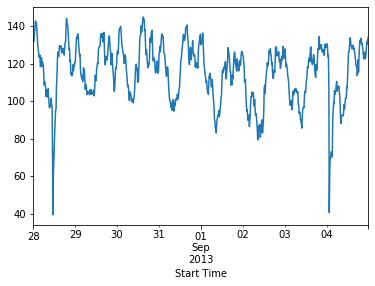

In [9]:
df_filter['L.Traffic.User.Avg (None)'].plot()

#df_filter['DL user tput'].plot()

#sns.distplot(np.log(df_filter['DL user tput']))
#np.log(df_filter['DL user tput']).plot()

In [65]:
np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)'])[1][0]

#sns.regplot(df_filter['DL user tput'],df_filter['L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)'])

-0.6447987977514091

-0.728303221924005

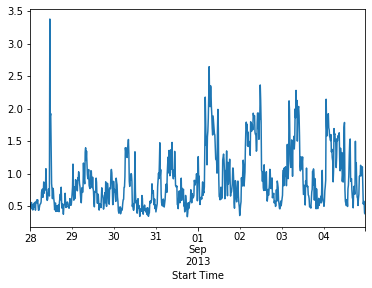

In [10]:
df_filter['DL user tput'].plot()

np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.User.Avg (None)'])[1][0]

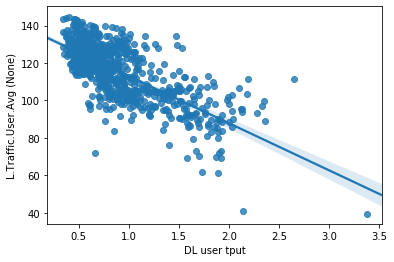

In [28]:
sns.regplot(df_filter['DL user tput'],df_filter['L.Traffic.User.Avg (None)'])

In [45]:
#sns.pairplot(df_filter)


corrMatrix = df_filter.corr()
#plt.matshow(corrMatrix)
#print (corrMatrix)

In [46]:
drop_columns=list(corrMatrix['DL user tput'][abs(corrMatrix['DL user tput'])<0.65].index)
drop_columns

['L.Traffic.UL.SCH.QPSK.ErrTB.Ibler (None)',
 'L.Traffic.UL.SCH.QPSK.ErrTB.Rbler (None)',
 'L.Traffic.UL.SCH.QPSK.TB (None)',
 'L.Traffic.UL.SCH.QPSK.TB.bits (bit)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans (None)',
 'L.Traffic.UL.SCH.QPSK.TB.Retrans.bits (bit)',
 'L.Traffic.DL.PktDelay.Num.QCI.9 (packet)',
 'L.Traffic.DL.PktDelay.Time.QCI.9 (ms)',
 'L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)',
 'L.Traffic.DL.PktUuLoss.Tot.QCI.9 (packet)',
 'L.Traffic.UL.PktLoss.Loss.QCI.9 (packet)',
 'DL RBLER (%)',
 'L.Thrp.bits.DL (bit)',
 'L.Thrp.bits.DL.Max (bit)',
 'L.Thrp.bits.DL.QCI.9 (bit)',
 'L.Thrp.bits.DL.QCI.9.Max (bit)',
 'L.Thrp.bits.DL.SRB (bit)',
 'L.Thrp.bits.UL (bit)',
 'L.Thrp.bits.UL.Max (bit)',
 'L.Thrp.bits.UL.QCI.9 (bit)',
 'L.Thrp.bits.UL.SRB (bit)',
 'L.Thrp.bits.UL.QCI.9.Max (bit)',
 'L.Thrp.Time.Cell.DL (s)',
 'L.Thrp.Time.Cell.UL (s)',
 'L.Thrp.Time.UL (ms)',
 'L.Thrp.Time.UL.QCI.9 (ms)',
 'L.UECNTX.AbnormRel (times)',
 'L.UECNTX.NormRel (times)',
 'L.Traffic.BCH.TB.bits (bit)',


In [47]:
df_filter=df_filter.drop(drop_columns,axis=1)

In [ ]:
df['L.Traffic.DL.PktUuLoss.Loss.QCI.9 (packet)']

In [48]:
df_filter.columns

Index(['L.Traffic.UL.PktLoss.Tot.QCI.9 (packet)',
       'L.PDCP.DL.RoHC.HdrCompRatio (%)', 'L.PDCP.DL.RoHC.PktCompRatio (%)',
       'L.PDCP.Tx.Disc.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.Tx.TotRev.Trf.SDU.QCI.9 (packet)',
       'L.PDCP.UL.RoHC.FailDecompRatio (%)', 'L.Traffic.CEU.Avg (None)',
       'L.Traffic.User.ULData.Avg (None)', 'L.Traffic.User.DLData.Avg (None)',
       'L.Traffic.User.Max (None)', 'L.Traffic.User.DLData.Max (None)',
       'L.Traffic.User.Avg (None)', 'L.Traffic.CEU.Max (None)',
       'L.Traffic.User.ULData.Max (None)', 'L.E-RAB.SessionTime.QCI9 (s)',
       'L.E-RAB.SessionTime.UE (s)', 'L.Thrp.Time.DL (ms)',
       'L.Thrp.Time.DL.QCI.9 (ms)', 'L.Traffic.DRB (None)',
       'L.Traffic.DRB.QCI.9 (None)',
       'L.Traffic.UL.SCH.64QAM.ErrTB.Ibler (None)',
       'L.Traffic.UL.SCH.64QAM.ErrTB.Rbler (None)',
       'L.Traffic.UL.SCH.64QAM.TB (None)',
       'L.Traffic.UL.SCH.64QAM.TB.bits (bit)',
       'L.Traffic.UL.SCH.64QAM.TB.Retrans (None)',
       'L.

In [50]:
alpha=0.3
ses=SimpleExpSmoothing(df_filter['DL user tput'],initialization_method='legacy-heuristic')

In [52]:
res=ses.fit(smoothing_level=alpha,optimized=False)

In [53]:
df_filter['SES']=res.predict(start=df_filter.index[0],end=df_filter.index[-1])

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_filter['SES']

Start Time
2013-08-28 00:00:00    0.494179
2013-08-28 00:15:00    0.494179
2013-08-28 00:30:00    0.502145
2013-08-28 00:45:00    0.503570
2013-08-28 01:00:00    0.520284
                         ...   
2013-09-04 22:45:00    0.953573
2013-09-04 23:00:00    0.828630
2013-09-04 23:15:00    0.752689
2013-09-04 23:30:00    0.699972
2013-09-04 23:45:00    0.608949
Freq: 15T, Name: SES, Length: 768, dtype: float64

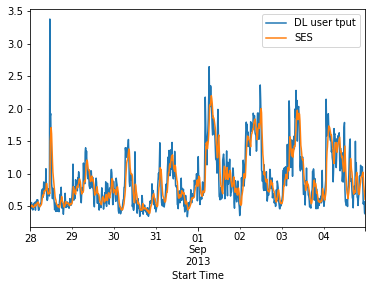

In [56]:
df_filter[['DL user tput','SES']].plot()

In [201]:
Ntest=96
train=df_filter.iloc[:-Ntest]
test=df_filter.iloc[-Ntest:]

In [60]:
ses=SimpleExpSmoothing(train['DL user tput'],initialization_method='legacy-heuristic')
res=ses.fit()

In [202]:
train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


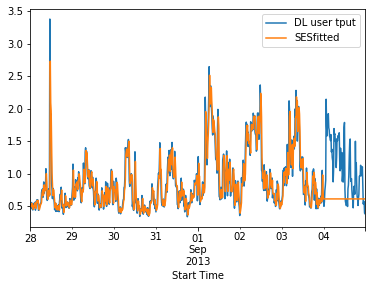

In [63]:
df_filter.loc[train_idx,'SESfitted']=res.fittedvalues
df_filter.loc[test_idx,'SESfitted']=res.forecast(Ntest)
df_filter[['DL user tput','SESfitted']].plot()

In [68]:
holt=Holt(train['DL user tput'],initialization_method='legacy-heuristic')
res_h=holt.fit()

In [87]:
df_filter.loc[train_idx,'Holt']=res_h.fittedvalues
df_filter.loc[test_idx,'Holt']=res_h.forecast(Ntest)

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


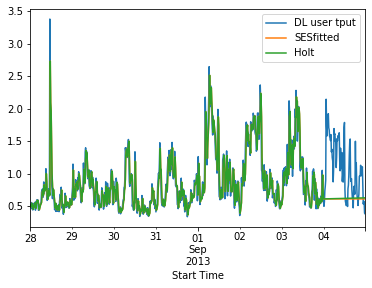

In [88]:
df_filter[['DL user tput','SESfitted','Holt']].plot()

In [225]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='estimated',damped_trend=False,trend='add',seasonal='mul',use_boxcox=False,seasonal_periods=96)
res_hw=HW.fit()

C:\Users\Ahmad\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


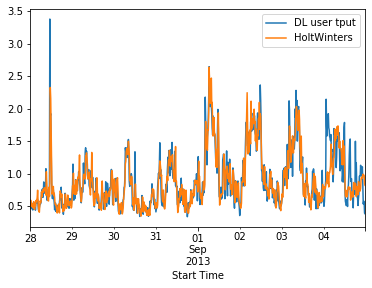

In [226]:
df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
#df_filter['HoltWinters']=np.sqrt(df_filter['HoltWinters'])
df_filter[['DL user tput','HoltWinters']].plot()

In [227]:
test['HW']=(res_hw.forecast(Ntest))

C:\Users\Ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.20484488947215385

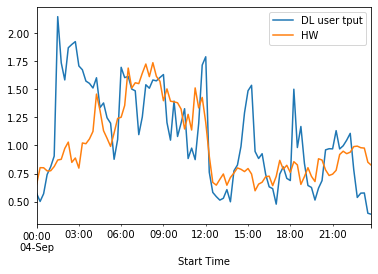

In [228]:
test[['DL user tput','HW']].plot()
r2_score(test['DL user tput'],test['HW'])

In [103]:
df_filter['DL user tput'].iloc[-Ntest:].min()

0.38699048076380715

In [171]:
mean_squared_error(test['DL user tput'],test['HW'])

0.16085181356443537

In [219]:
h=96
steps=10
Ntest=len(df_filter)-96-steps+1

In [220]:
def walkforward(trend_type,seasonal_type,damped_trend,init_method,use_boxcox,debug=False):
    errors=[]
    seen_last=False
    steps_completed=0
    
    for end_of_train in range(Ntest, len(df)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        hw=ExponentialSmoothing(
        train['DL user tput'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=96,
        use_boxcox=use_boxcox)
        res_hw=hw.fit()
        
        fcast=res_hw.forecast(h)
        error=mean_squared_error(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
            
        return np.mean(errors)
    
    

In [221]:
trend_type_list=['add']
seasonal_type_list=['add','mul']
damped_trend_list=[True,False]
init_method_list=['estimated','heuristic','legacy-heuristic']
use_boxcox_list=[True,False,0]

tupe_of_option_lists=(
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list   

)

In [222]:
best_score=float('inf')
best_options=None
for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    if score < best_score:
        print("Best score so far:",score)
        best_score=score
        best_options=x

Best score so far: 0.33326894632827425
Best score so far: 0.23288932812652585


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\

Best score so far: 0.17959419224947795


C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
C:\Users\Ahmad\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [224]:
print("best score:",best_score)

trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print("trend_type",trend_type)
print("seasonal_type",seasonal_type)
print("damped_trend",damped_trend)
print("init_method",init_method)
print("use_boxcox",use_boxcox)

best score: 0.17959419224947795
trend_type add
seasonal_type mul
damped_trend False
init_method estimated
use_boxcox False
